In [1]:
# python utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

# SMOTE
from imblearn.over_sampling import SMOTE

# Tensorflow
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy as sp

2024-06-25 13:15:06.216854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 13:15:06.217148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 13:15:06.403086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 사용 가능한 GPU 목록 출력
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


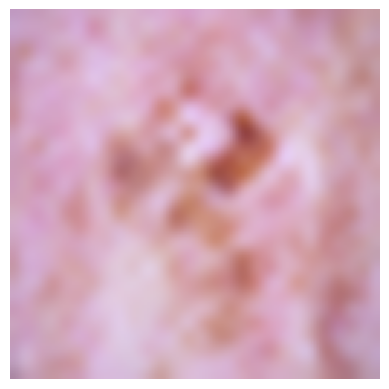

In [6]:
# 이미지 불러오기 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# 데이터 로드 및 전처리
img = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
img = img.drop(columns=['label'])

# 첫 번째 이미지 추출 및 재구성
test_img = np.array(img.loc[0])
test_img = test_img.reshape(28, 28, 3)

# 이미지 크기 조정
test_img = sp.ndimage.zoom(test_img, (128 / 28, 128 / 28, 1))
test_img = test_img.reshape(-1, 128, 128, 3)

# 시각화
plt.imshow(test_img[0])
plt.axis('off')  # 축 제거
plt.show()


In [3]:
# Image SIZE
IMAGE_SIZE = 128

# Load data and preprocess labels
data_img = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
X = data_img.drop(columns = ['label'])
# 0: akiec, 1: bcc, 2: bkl, 3: df, 4: nv, 5: vasc, 6: mel
y = data_img['label']
X = np.array(X).reshape(-1, 28, 28, 3)
t = np.zeros([len(X), IMAGE_SIZE, IMAGE_SIZE, 3], dtype=np.float32)
for i in range(len(X)):
    t[i] = sp.ndimage.zoom(X[i], (IMAGE_SIZE/28, IMAGE_SIZE/28, 1))
X = np.array(t).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
X = resnet_preprocess(X)


In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1030)
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=1030)

In [5]:
# SMOTE 적용 (트레이닝 데이터에만)
smote = SMOTE(random_state=1030)
X_tr_res, y_tr_res = smote.fit_resample(X_tr.reshape(X_tr.shape[0], -1), y_tr)
X_tr_res = X_tr_res.reshape(-1, 128, 128, 3)

In [6]:
# 원-핫 인코딩 적용
y_tr_res = to_categorical(y_tr_res, num_classes=7)
y_va = to_categorical(y_va, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [7]:
# Image data generators
tr_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255.0
)
va_generator = ImageDataGenerator(
    rescale=1/255.0
)

In [8]:
# SMOTE 적용 후 트레이닝 데이터 증강
flow_tr_gen = tr_generator.flow(X_tr_res, y_tr_res, batch_size=16, shuffle=True)

In [9]:
# 검증 데이터 증강 설정
flow_val_gen = va_generator.flow(X_va, y_va, batch_size=16, shuffle=False)

In [ ]:
def model_resnet50(in_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=7):
    input_tensor = Input(shape=in_shape)
    # ResNet50 모델을 로드하고, 최상위 레이어는 제외
    base_model = ResNet50(input_tensor=input_tensor, include_top=False, weights='/kaggle/input/resnet50/tensorflow2/resnet50_tesorflow/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5') 
    bm_output = base_model.output

    # 추가할 새로운 Global Average Pooling Layer와 Dense Layer
    x = GlobalAveragePooling2D()(bm_output)
    predictions = Dense(n_classes, activation='softmax')(x)
    
    # 최종 모델 구성
    model = Model(inputs=base_model.input, outputs=predictions)
    model.summary()
    return model

with tf.device('/GPU:0'):
    # 모델 구조 정의
    model = model_resnet50(in_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=7)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "functional_5"

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Callbacks
# 검증 손실이 개선되지 않을 때 학습률을 조정
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 일정 기간 동안 검증 손실이 개선되지 않으면 학습을 조기 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=4, mode='min', verbose=1)

In [19]:
# Fit the model
history = model.fit(
    flow_tr_gen,
    steps_per_epoch=int(np.ceil(X_tr.shape[0]/16)),  # 올바르게 배치 사이즈로 나눈 값
    validation_data=flow_val_gen,
    validation_steps=int(np.ceil(X_va.shape[0]/16)),  # 마찬가지로 올바른 계산
    epochs=50
)

Epoch 1/50
  4/401 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.1250 - loss: 2.3757

W0000 00:00:1715442076.944214     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5582 - loss: 1.1733

W0000 00:00:1715442120.465969      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


401/401 ━━━━━━━━━━━━━━━━━━━━ 96s 116ms/step - accuracy: 0.5585 - loss: 1.1727 - val_accuracy: 0.1079 - val_loss: 23.4381
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.7644 - loss: 0.6573 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.7913 - loss: 0.5587 - val_accuracy: 0.4847 - val_loss: 1.7019
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.8215 - loss: 0.4782 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8362 - loss: 0.4412 - val_accuracy: 0.7336 - val_loss: 0.7152
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.8591 - loss: 0.3825 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.8718 - loss: 0.3500 - val_accuracy: 0.7305 - val_loss: 0.8044
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.8643 - 

In [21]:
# Model Test

test_generator = ImageDataGenerator(
    rescale=1/255.0
)
flow_test_gen = test_generator.flow(X_test, y_test, batch_size=16, shuffle=False)
model.evaluate(flow_test_gen)

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7905 - loss: 0.8031


[0.8290690779685974, 0.784323513507843]

Model: "functional_7"

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


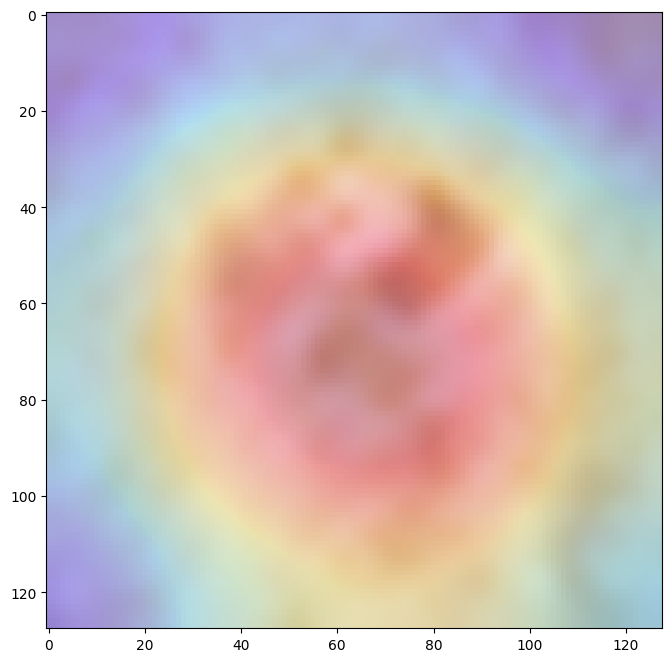

Feature shape: (1, 4, 4, 2048)
Weight shape: (2048,)


In [22]:
# 모델의 입력 및 중간 레이어와 출력을 연결
cam_model = Model(inputs=model.input, outputs=(model.layers[-5].output, model.layers[-1].output))
cam_model.summary()

def show_cam(image_value, features, results):
    features_for_img = features[0] 
    prediction = np.argmax(results) 

    # 글로벌 평균 풀링 레이어로부터 연결된 가중치 가져오기
    gap_weights = model.layers[-1].get_weights()[0]
    class_activation_weights = gap_weights[:, prediction]

    # 이미지 크기에 맞게 특징 맵 크기 조정
    class_activation_features = sp.ndimage.zoom(features_for_img, (IMAGE_SIZE / features_for_img.shape[0], IMAGE_SIZE / features_for_img.shape[1], 1), order=2)
    cam_output = np.dot(class_activation_features, class_activation_weights)

    # 결과 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()

In [ ]:
# 이미지 불러오기 및 전처리
img = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
img = img.drop(columns=['label'])
test_img = np.array(img.loc[0])
test_img = test_img.reshape(28, 28, 3)
test_img = sp.ndimage.zoom(test_img, (IMAGE_SIZE / 28, IMAGE_SIZE / 28, 1))
test_img = test_img.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
test_img_proc = resnet_preprocess(test_img)

# 모델 예측
features, results = cam_model.predict(test_img_proc)

# CAM 표시
show_cam(test_img, features, results)

print("Feature shape:", features.shape)
w_out = model.layers[-5].get_weights()[0]
print("Weight shape:", w_out.shape